In [1]:
import casadi as ca
import numpy as np

def A_0_matrix(order):
    """
    Compute the A_0 matrix.
    
    A_0[r,n] = { Π_{m=0}^{r-1}(r - m) : r = n
                { 0                     : r ≠ n
    
    This is a diagonal matrix with falling factorials on the diagonal.
    
    Args:
        order: the polynomial order (matrix size will be (order+1) x (order+1))
    
    Returns:
        A_0 matrix of shape (order+1, order+1)
    """
    size = order + 1
    A_0 = np.zeros((size, size))
    for r in range(size):
        # Compute falling factorial: Π_{m=0}^{r-1}(r - m) = r!
        falling_factorial = 1
        for m in range(r):
            falling_factorial *= (r - m)
        A_0[r, r] = falling_factorial
    return A_0


def A_tau_matrix(order, tau):
    """
    Compute the A_tau matrix.
    
    A_τ[r,n] = { (Π_{m=0}^{r-1}(n - m)) * τ^{n-r} : n ≥ r
                { 0                                  : n < r
    
    Args:
        order: the polynomial order (matrix size will be (order+1) x (order+1))
        tau: the segment time duration (τ value)
    
    Returns:
        A_tau matrix of shape (order+1, order+1)
    """
    size = order + 1
    A_tau = np.zeros((size, size))
    for r in range(size):
        for n in range(size):
            if n >= r:
                # Compute falling factorial: Π_{m=0}^{r-1}(n - m)
                falling_factorial = 1
                for m in range(r):
                    falling_factorial *= (n - m)
                # Multiply by τ^(n-r)
                A_tau[r, n] = falling_factorial * (tau ** (n - r))
    return A_tau


def get_big_A(order,tau, K):
    A_rows = []
    for i in range(K-1):
        if i == 0:
            print(-A_tau_matrix(order,tau))
            print(A_0_matrix(order))
            row = ca.horzcat(-A_tau_matrix(order,tau), A_0_matrix(order), np.zeros((order+1, (K-2-i)*(order+1))))
        else:
            row = ca.horzcat(np.zeros((order+1,i*(order+1))), -A_tau_matrix(order,tau), A_0_matrix(order), np.zeros((order+1, (K-2-i)*(order+1))))
        A_rows.append(np.array(row)[:])
        # A_rows.append(row[0:3][:]) # Only enforce continuity of position, velocity, acceleration
    A = ca.vertcat(*A_rows)
    return A

big_A = get_big_A(order=4, tau=1.0, K=4)

# Print big_A in a pretty, aligned format with no wrapping
np.set_printoptions(precision=1, suppress=True, linewidth=np.inf, threshold=np.inf)
print("\nBig A matrix:")
print(np.array(big_A))


[[ -1.  -1.  -1.  -1.  -1.]
 [ -0.  -1.  -2.  -3.  -4.]
 [ -0.  -0.  -2.  -6. -12.]
 [ -0.  -0.  -0.  -6. -24.]
 [ -0.  -0.  -0.  -0. -24.]]
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  6.  0.]
 [ 0.  0.  0.  0. 24.]]

Big A matrix:
[[ -1.  -1.  -1.  -1.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -1.  -2.  -3.  -4.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -0.  -2.  -6. -12.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -0.  -0.  -6. -24.   0.   0.   0.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -0.  -0.  -0.  -0. -24.   0.   0.   0.   0.  24.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  -1.  -1.  -1.  -1.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  -0.  -1.  -2.  -3.  -4.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 

In [2]:
row

NameError: name 'row' is not defined

In [3]:
def Q_r_matrix(order, r, i, l, tau):
    """
    Compute Q_r^il matrix element.
    
    Q_r^il[i,l] = { 2 * (Π_{m=0}^{r-1}(i - m)(l - m)) * τ^{i+l-2r+1} / (i+l-2r+1) : i ≥ r ∧ l ≥ r
                   { 0                                                            : i < r ∨ l < r
    
    Args:
        order: polynomial order (size of Q_r will be (order+1) x (order+1))
        r: derivative order (0 to order)
        i: row index
        l: column index
        tau: segment time duration
    
    Returns:
        scalar Q_r^il value
    """
    if i < r or l < r:
        return 0.0
    
    # Compute falling factorial: Π_{m=0}^{r-1}(i - m)(l - m)
    falling_factorial = 1.0
    for m in range(r):
        falling_factorial *= (i - m) * (l - m)
    
    # Compute exponent: τ^{i+l-2r+1}
    exponent = tau ** (i + l - 2*r + 1)
    
    # Compute denominator: (i+l-2r+1)
    denominator = i + l - 2*r + 1
    
    return 2.0 * falling_factorial * exponent / denominator


def Q_total_matrix(order, tau, weights=None):
    """
    Compute the total cost matrix Q as a weighted sum of Q_r matrices.
    
    Q = Σ_{r=0}^{order} c_r * Q_r
    
    where c_r are penalty weights on the r-th derivative, and each Q_r is built
    from the Q_r^il elements.
    
    Args:
        order: polynomial order
        tau: segment time duration
        weights: list of penalty weights [c_0, c_1, c_2, ...] for derivatives.
                If None, defaults to uniform weights of 1.0
    
    Returns:
        Q matrix of shape (order+1, order+1) as numpy array
    """
    size = order + 1
    Q = np.zeros((size, size))
    
    if weights is None:
        weights = np.ones(size)
    
    # Sum over all derivative orders r
    for r in range(size):
        Q_r = np.zeros((size, size))
        # Build Q_r matrix
        for i in range(size):
            for l in range(size):
                Q_r[i, l] = Q_r_matrix(order, r, i, l, tau)
        
        # Add weighted Q_r to total Q
        Q += weights[r] * Q_r
    
    return Q


# Example usage
order = 4
tau = 1.0
weights = [1.0, 1.0, 1.0, 1.0, 1.0]  # Equal weights on all derivatives

Q = Q_total_matrix(order, tau, weights=weights)

print(f"Q matrix (order={order}, tau={tau}):")
np.set_printoptions(precision=2, suppress=True, linewidth=np.inf, threshold=np.inf)
print(Q)


def Q_block_diagonal(order, tau, segments, weights=None):
    """
    Create a block diagonal matrix with Q matrices on the diagonal.
    
    The result is a matrix of size (segments*(order+1)) x (segments*(order+1))
    with Q matrices placed on the diagonal for each segment.
    
    Args:
        order: polynomial order
        tau: segment time duration (same for all segments)
        segments: number of segments K
        weights: list of penalty weights [c_0, c_1, c_2, ...] for derivatives.
                If None, defaults to uniform weights of 1.0
                This same weight set is used for all segment Q matrices.
    
    Returns:
        Block diagonal matrix of shape (segments*(order+1), segments*(order+1))
    """
    # Compute single Q matrix
    Q_single = Q_total_matrix(order, tau, weights=weights)
    
    size = order + 1
    total_size = segments * size
    
    # Create block diagonal matrix
    Q_block = np.zeros((total_size, total_size))
    
    for k in range(segments):
        start_idx = k * size
        end_idx = (k + 1) * size
        Q_block[start_idx:end_idx, start_idx:end_idx] = Q_single
    
    return Q_block


# Example: create block diagonal Q with 4 segments
segments = 4
Q_block = Q_block_diagonal(order, tau, segments, weights=weights)

print(f"\nBlock diagonal Q matrix ({segments} segments, order={order}):")
print(f"Shape: {Q_block.shape}")
print(Q_block)


Q matrix (order=4, tau=1.0):
[[   2.      1.      0.67    0.5     0.4 ]
 [   1.      2.67    2.5     2.4     2.33]
 [   0.67    2.5    11.07   15.33   19.49]
 [   0.5     2.4    15.33   99.89  184.25]
 [   0.4     2.33   19.49  184.25 1598.39]]

Block diagonal Q matrix (4 segments, order=4):
Shape: (20, 20)
[[   2.      1.      0.67    0.5     0.4     0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.  ]
 [   1.      2.67    2.5     2.4     2.33    0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.  ]
 [   0.67    2.5    11.07   15.33   19.49    0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.  ]
 [   0.5     2.4    15.33   99.89  184.25    0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.  ]
 [   0.4     2.33   19.49  184.25 1598.

In [4]:
# Example 1: Simple 3-segment trajectory with boundary conditions
result = solve_qp_trajectory(
    order=7,
    tau=1.0,
    segments=3,
    weights=[0, 0, 0, 0, 1.0, 0, 0, 0],  # minimum snap
    boundary_conditions=[
        [0.0, None],      # Segment 0: start at 0
        [None, None],     # Segment 1: free
        [None, 10.0]       # Segment 2: end at 0
    ],
    continuity_discontinuities=None
)

print("Example 1: Simple trajectory")
print(f"  Order: {result['order']}")
print(f"  Segments: {result['segments']}")
print(f"  Polynomial shape: {result['polys'].shape}")
print(f"  Constraint matrix shape: {result['A'].shape}")
print(f"  Cost matrix shape: {result['Q'].shape}")
print(f"  Solution found successfully!")
print(f"\nPolynomial coefficients (first 3):")
print(result['polys'][:3])

polys = np.array(result['polys']).T.reshape(3,7+1)

# polynomials_example = [
#     [1, 2, 1],      # coefficients for P_0
#     [0, 0.5, 0.5],  # coefficients for P_1
#     [2, -1, 0.3]    # coefficients for P_2
# ]
segment_times_example = [1.0]*3  # tau_0, tau_1, tau_2

fig, ax = plot_piecewise_polynomials(polys, segment_times_example, 
                                      title="Example: Piecewise Polynomials")
plt.tight_layout()
plt.show()


NameError: name 'solve_qp_trajectory' is not defined

In [5]:
def get_A_constraints(order, tau, segments):
    """
    Build the block diagonal constraint matrix.
    
    Structure:
    [ A_0^0    0      0      0    ...    0   ]
    [ 0      A_0^1    0      0    ...    0   ]
    [ 0        0    A_0^2    0    ...    0   ]
    [ 0        0      0    A_0^3  ...    0   ]
    [ ...      ...    ...   ...   ...   ... ]
    [ 0        0      0      0    ...  A_0^K ]
    [ 0        0      0      0    ...  A_τ^K ]
    
    Where:
    - First (K-1) rows: diagonal blocks of A_0 matrices (one per segment)
    - Last row: A_τ matrix for the last segment (continuity constraint)
    
    Args:
        order: polynomial order
        tau: segment time duration
        segments: number of segments K
    
    Returns:
        Constraint matrix A of shape ((order+1)*segments, (order+1)*segments)
    """
    size = order + 1
    total_size = segments * size
    
    # Create the constraint matrix
    A_constraints = np.zeros((total_size, total_size))
    
    # Fill diagonal blocks with A_0 matrices
    for k in range(segments - 1):
        start_idx = k * size
        end_idx = (k + 1) * size
        A_constraints[start_idx:end_idx, start_idx:end_idx] = A_0_matrix(order)
    
    # Last block: A_0 on diagonal, A_tau below it (continuity constraint)
    last_diag_start = (segments - 1) * size
    last_diag_end = segments * size
    A_constraints[last_diag_start:last_diag_end, last_diag_start:last_diag_end] = A_0_matrix(order)
    
    # Add A_tau constraint row at the bottom (continuity from last segment)
    # This enforces continuity: P_k(tau) = P_{k+1}(0)
    # We append a row for this constraint
    A_tau_constraint = A_tau_matrix(order, tau)
    A_constraints = np.vstack([
        A_constraints,
        np.hstack([np.zeros((size, (segments-1)*size)), A_tau_constraint])
    ])
    
    return A_constraints

get_A_constraints(5, 1.0, 3)

array([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  24.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   

[[0.0, None], [None, None], [None, None], [10, None], [None, None], [None, None], [-10, None], [None, None], [None, None], [20, None], [None, None], [None, None], [-20, None], [None, None], [None, 0]]
[[   -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.]
 [   -0.    -1.    -2.    -3.    -4.    -5.    -6.    -7.]
 [   -0.    -0.    -2.    -6.   -12.   -20.   -30.   -42.]
 [   -0.    -0.    -0.    -6.   -24.   -60.  -120.  -210.]
 [   -0.    -0.    -0.    -0.   -24.  -120.  -360.  -840.]
 [   -0.    -0.    -0.    -0.    -0.  -120.  -720. -2520.]
 [   -0.    -0.    -0.    -0.    -0.    -0.  -720. -5040.]
 [   -0.    -0.    -0.    -0.    -0.    -0.    -0. -5040.]]
[[   1.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    1.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    2.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    6.    0.    0.    0.    0.]
 [   0.    0.    0.    0.   24.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  120.    0.    0.]
 [   0.    0.    0. 

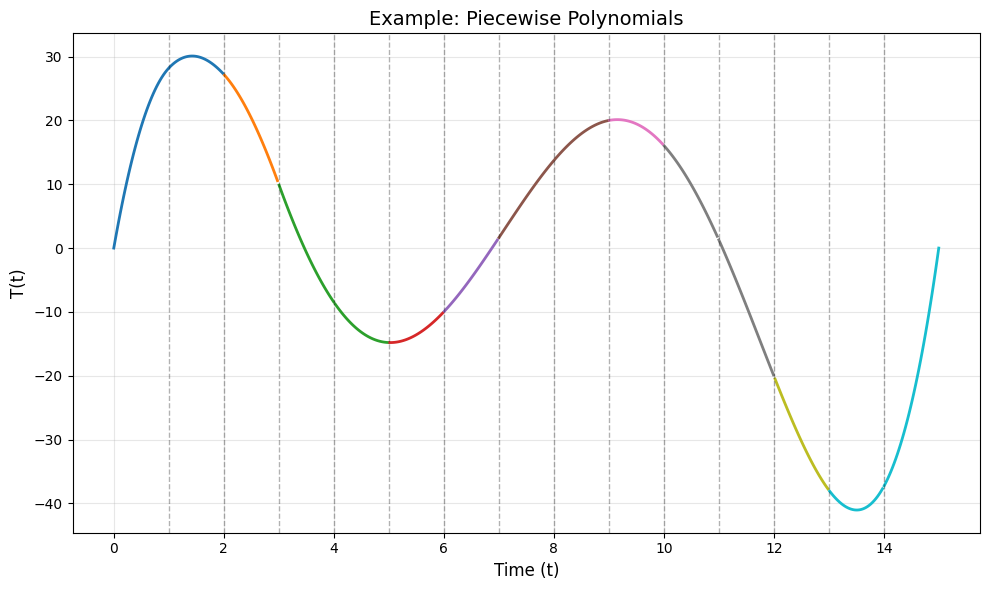

In [ ]:
# Quadratic Programming Setup with Arbitrary Boundary Conditions
order = 7
tau = 1.0
segments = 15
weights = [0]*(order+1) # minimum snap
weights[4] = 100

# Define boundary conditions for each segment
# boundary_conditions[k] = [val_at_0, val_at_tau] for segment k
# If None, no boundary constraint for that segment endpoint
boundary_conditions = [
    [0.0, None],      #1 Segment 0: start at 0, end is free
    [None, None],      #2 Se00gment 3: start is free, end at 1
    [None, None],      #3 Se00gment 3: start is free, end at 1
    [10, None],      #4 Se00gment 3: start is free, end at 1
    [None, None],      #5 Se00gment 3: start is free, end at 1
    [None, None],      #6 Se00gment 3: start is free, end at 1
    [-10, None],      #7 Se00gment 3: start is free, end at 1
    [None, None],      #8 Se00gment 3: start is free, end at 1
    [None, None],      #9 Se00gment 3: start is free, end at 1
    [20, None],      #10 Se00gment 3: start is free, end at 1
    [None, None],      #11 Se00gment 3: start is free, end at 1
    [None, None],      #12 Se00gment 3: start is free, end at 1
    [-20, None],      #13 Se00gment : start is free, end at 1
    [None, None],      #15 Se00gment 3: start is free, end at 1
    [None, 0],      #end Se00gment 3: start is free, end at 1
]

print(boundary_conditions)

# Get continuity constraints from get_big_A
# This gives us (K-1)*(order+1) = 3*5 = 15 constraints for continuity
A_continuity = get_big_A(order, tau, segments)
size = order + 1

# Build boundary constraint matrix
boundary_rows = []
boundary_values = []

for k, (start_val, end_val) in enumerate(boundary_conditions):
    # Constraint for segment start: P_k(0)
    if start_val is not None:
        row = np.zeros((1, segments * size))
        # At t=0, only the constant term (coefficient a_0) matters
        row[0, k*size] = 1.0  # P_k(0) = a_0
        boundary_rows.append(row)
        boundary_values.append(start_val)
    
    # Constraint for segment end: P_k(tau)
    if end_val is not None:
        row = np.zeros((1, segments * size))
        # P_k(tau) = a_0 + a_1*tau + a_2*tau^2 + ... + a_n*tau^n
        for n in range(size):
            row[0, k*size + n] = tau ** n
        boundary_rows.append(row)
        boundary_values.append(end_val)

# Combine all constraints
if boundary_rows:
    A_boundary = np.vstack(boundary_rows)
    A = ca.vertcat(A_continuity, ca.DM(A_boundary))
    b_continuity = ca.DM.zeros(A_continuity.shape[0], 1)

    # Enforce accleeration jump
    b_continuity[2] = 10
    b_continuity[10] = -5
    b_continuity[18] = 20

    b_boundary = ca.DM(np.array(boundary_values).reshape(-1, 1))
    b = ca.vertcat(b_continuity, b_boundary)
else:
    # No boundary conditions, only continuity
    A = A_continuity
    b = ca.DM.zeros(A_continuity.shape[0], 1)



print("Boundary Conditions Setup:")
for k, (start_val, end_val) in enumerate(boundary_conditions):
    print(f"  Segment {k}: P_{k}(0) = {start_val}, P_{k}({tau}) = {end_val}")

print(f"\nConstraint matrix shapes:")
print(f"  A_continuity: {A_continuity.shape}")
if boundary_rows:
    print(f"  A_boundary: {A_boundary.shape}")
print(f"  A (total): {A.shape}")
print(f"  b (total): {b.shape}")

p = ca.SX.sym('p', (order+1)*(segments))

# Define QP objective
Q = Q_block_diagonal(order, tau, segments, weights=weights)

print(f"\nProblem dimensions:")
print(f"  Decision variables: {p.shape[0]}")
print(f"  Equality constraints: {A.shape[0]}")
print(f"  Q matrix shape: {Q.shape}")

objective = ca.mtimes(p.T, ca.mtimes(Q, p))

# Create optimizer
opts = {}
nlp = {'x': p, 'f': objective, 'g': ca.mtimes(A, p) - b}
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

# Solve with equality constraints (g = 0)
solution = solver(x0=ca.DM([0]*p.shape[0]), lbg=ca.DM([0]*b.shape[0]), ubg=ca.DM([0]*b.shape[0]))
x_opt = solution['x']
print("\nOptimal solution computed successfully")

import matplotlib.pyplot as plt
import numpy as np


# Example usage: plot three quadratic polynomials
# P_0(t) = 1 + 2*t + t^2
# P_1(t) = 0.5*t + 0.5*t^2
# P_2(t) = 2 - t + 0.3*t^2

polys = np.array(x_opt).T.reshape(segments,order+1)

# polynomials_example = [
#     [1, 2, 1],      # coefficients for P_0
#     [0, 0.5, 0.5],  # coefficients for P_1
#     [2, -1, 0.3]    # coefficients for P_2
# ]
segment_times_example = [1.0]*segments  # tau_0, tau_1, tau_2

fig, ax = plot_piecewise_polynomials(polys, segment_times_example, 
                                      title="Example: Piecewise Polynomials")
plt.tight_layout()
plt.show()


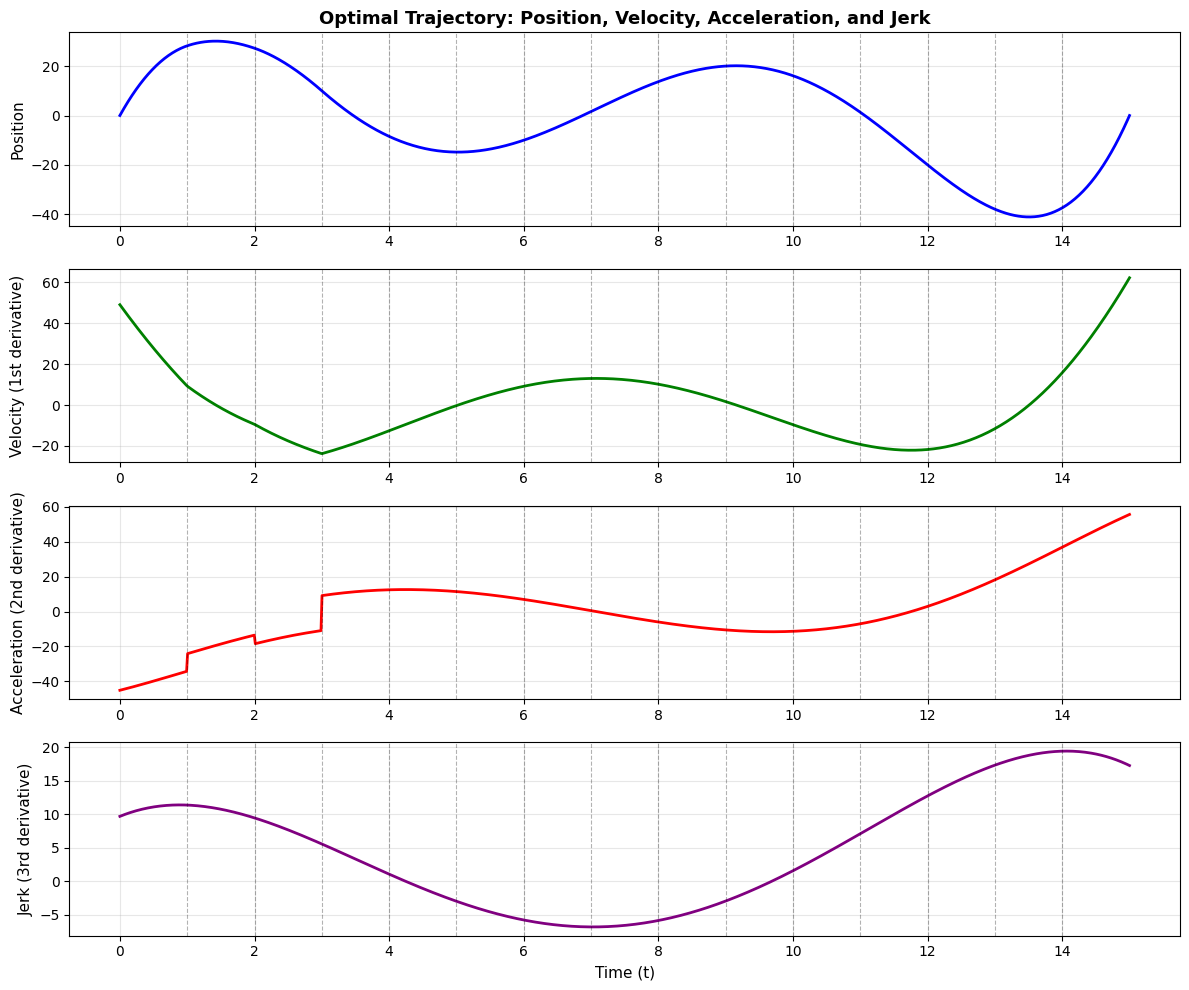

In [ ]:
# Plot Position, Velocity, Acceleration, and Jerk (1st, 2nd, 3rd Derivatives)

def compute_polynomial_derivative(coefficients, derivative_order=1):
    """
    Compute the coefficients of the derivative of a polynomial.
    
    Given polynomial P(t) = a_0 + a_1*t + a_2*t^2 + ... + a_n*t^n,
    returns coefficients of dP/dt = a_1 + 2*a_2*t + 3*a_3*t^2 + ...
    
    Args:
        coefficients: array [a_0, a_1, a_2, ..., a_n]
        derivative_order: which derivative to compute (1, 2, 3, ...)
    
    Returns:
        coefficients of the derivative polynomial
    """
    result = np.array(coefficients, dtype=float)
    for _ in range(derivative_order):
        if len(result) <= 1:
            return np.array([0.0])
        result = np.array([result[i] * i for i in range(1, len(result))])
    return result if len(result) > 0 else np.array([0.0])


def plot_derivatives(polynomials, segment_times, title="Trajectory Derivatives"):
    """
    Plot position, velocity (1st derivative), acceleration (2nd derivative),
    and jerk (3rd derivative) for a piecewise polynomial trajectory.
    
    Args:
        polynomials: array of shape (segments, order+1) with polynomial coefficients
        segment_times: list of segment durations
        title: plot title
    """
    # Compute cumulative segment boundaries (Gamma_k)
    gamma = [0]
    for tau in segment_times:
        gamma.append(gamma[-1] + tau)
    
    # Auto-generate evaluation points
    t_eval = np.linspace(0, gamma[-1], 1000)
    
    # Initialize arrays for each derivative order
    position = np.zeros_like(t_eval)
    velocity = np.zeros_like(t_eval)
    acceleration = np.zeros_like(t_eval)
    jerk = np.zeros_like(t_eval)
    
    # Compute derivatives for each segment
    derivatives = [None] * len(polynomials)  # 0th derivative (position)
    for k in range(len(polynomials)):
        # 0th order (position)
        derivatives[k] = [np.array(polynomials[k])]
        # 1st order (velocity)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 1))
        # 2nd order (acceleration)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 2))
        # 3rd order (jerk)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 3))
    
    # Evaluate at each time point
    for i, t in enumerate(t_eval):
        # Find which segment t belongs to
        for k in range(len(polynomials)):
            if gamma[k] <= t <= gamma[k+1]:
                t_local = t - gamma[k]
                # Evaluate all derivatives
                position[i] = np.polyval(derivatives[k][0][::-1], t_local)
                velocity[i] = np.polyval(derivatives[k][1][::-1], t_local) if len(derivatives[k][1]) > 0 else 0
                acceleration[i] = np.polyval(derivatives[k][2][::-1], t_local) if len(derivatives[k][2]) > 0 else 0
                jerk[i] = np.polyval(derivatives[k][3][::-1], t_local) if len(derivatives[k][3]) > 0 else 0
                break
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Plot position
    axes[0].plot(t_eval, position, 'b-', linewidth=2)
    axes[0].set_ylabel('Position', fontsize=11)
    axes[0].set_title(title, fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[0].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot velocity (1st derivative)
    axes[1].plot(t_eval, velocity, 'g-', linewidth=2)
    axes[1].set_ylabel('Velocity (1st derivative)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[1].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot acceleration (2nd derivative)
    axes[2].plot(t_eval, acceleration, 'r-', linewidth=2)
    axes[2].set_ylabel('Acceleration (2nd derivative)', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[2].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot jerk (3rd derivative)
    axes[3].plot(t_eval, jerk, 'purple', linewidth=2)
    axes[3].set_ylabel('Jerk (3rd derivative)', fontsize=11)
    axes[3].set_xlabel('Time (t)', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[3].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    return fig, axes

def compute_polynomial_derivative(coefficients, derivative_order=1):
    """
    Compute the coefficients of the derivative of a polynomial.
    
    Given polynomial P(t) = a_0 + a_1*t + a_2*t^2 + ... + a_n*t^n,
    returns coefficients of dP/dt = a_1 + 2*a_2*t + 3*a_3*t^2 + ...
    
    Args:
        coefficients: array [a_0, a_1, a_2, ..., a_n]
        derivative_order: which derivative to compute (1, 2, 3, ...)
    
    Returns:
        coefficients of the derivative polynomial
    """
    result = np.array(coefficients, dtype=float)
    for _ in range(derivative_order):
        if len(result) <= 1:
            return np.array([0.0])
        result = np.array([result[i] * i for i in range(1, len(result))])
    return result if len(result) > 0 else np.array([0.0])


def plot_derivatives(polynomials, segment_times, title="Trajectory Derivatives"):
    """
    Plot position, velocity (1st derivative), acceleration (2nd derivative),
    and jerk (3rd derivative) for a piecewise polynomial trajectory.
    
    Args:
        polynomials: array of shape (segments, order+1) with polynomial coefficients
        segment_times: list of segment durations
        title: plot title
    """
    # Compute cumulative segment boundaries (Gamma_k)
    gamma = [0]
    for tau in segment_times:
        gamma.append(gamma[-1] + tau)
    
    # Auto-generate evaluation points
    t_eval = np.linspace(0, gamma[-1], 1000)
    
    # Initialize arrays for each derivative order
    position = np.zeros_like(t_eval)
    velocity = np.zeros_like(t_eval)
    acceleration = np.zeros_like(t_eval)
    jerk = np.zeros_like(t_eval)
    
    # Compute derivatives for each segment
    derivatives = [None] * len(polynomials)  # 0th derivative (position)
    for k in range(len(polynomials)):
        # 0th order (position)
        derivatives[k] = [np.array(polynomials[k])]
        # 1st order (velocity)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 1))
        # 2nd order (acceleration)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 2))
        # 3rd order (jerk)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 3))
    
    # Evaluate at each time point
    for i, t in enumerate(t_eval):
        # Find which segment t belongs to
        for k in range(len(polynomials)):
            if gamma[k] <= t <= gamma[k+1]:
                t_local = t - gamma[k]
                # Evaluate all derivatives
                position[i] = np.polyval(derivatives[k][0][::-1], t_local)
                velocity[i] = np.polyval(derivatives[k][1][::-1], t_local) if len(derivatives[k][1]) > 0 else 0
                acceleration[i] = np.polyval(derivatives[k][2][::-1], t_local) if len(derivatives[k][2]) > 0 else 0
                jerk[i] = np.polyval(derivatives[k][3][::-1], t_local) if len(derivatives[k][3]) > 0 else 0
                break
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Plot position
    axes[0].plot(t_eval, position, 'b-', linewidth=2)
    axes[0].set_ylabel('Position', fontsize=11)
    axes[0].set_title(title, fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[0].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot velocity (1st derivative)
    axes[1].plot(t_eval, velocity, 'g-', linewidth=2)
    axes[1].set_ylabel('Velocity (1st derivative)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[1].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot acceleration (2nd derivative)
    axes[2].plot(t_eval, acceleration, 'r-', linewidth=2)
    axes[2].set_ylabel('Acceleration (2nd derivative)', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[2].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot jerk (3rd derivative)
    axes[3].plot(t_eval, jerk, 'purple', linewidth=2)
    axes[3].set_ylabel('Jerk (3rd derivative)', fontsize=11)
    axes[3].set_xlabel('Time (t)', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[3].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    return fig, axes


# Plot the derivatives
fig_derivs, axes_derivs = plot_derivatives(polys, segment_times_example, 
                                           title="Optimal Trajectory: Position, Velocity, Acceleration, and Jerk")
plt.show()

# Plot the derivatives
fig_derivs, axes_derivs = plot_derivatives(polys, segment_times_example, 
                                           title="Optimal Trajectory: Position, Velocity, Acceleration, and Jerk")
plt.show()


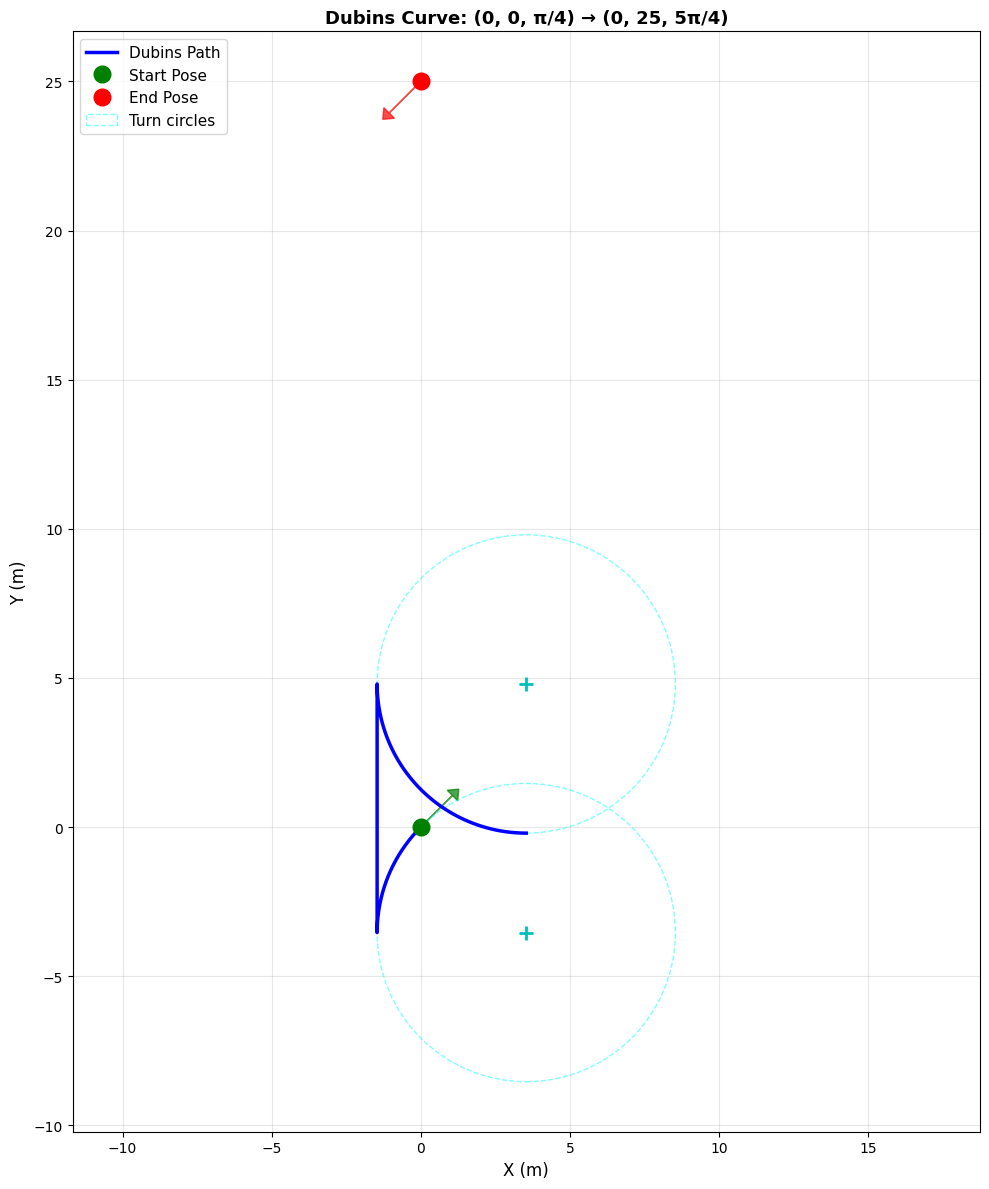

Dubins Curve Segments:

Arc 1 (LEFT turn):
  Center: (3.54, -3.54)
  Radius: 5.00
  Angle: 45.0°
  Start: (0.00, 0.00)
  End: (-1.46, -3.54)

Line Segment:
  Start: (-1.46, -3.54)
  End: (-1.46, 4.80)
  Length: 8.33
  Heading: 90.0°

Arc 2 (LEFT turn):
  Center: (3.54, 4.80)
  Radius: 5.00
  Angle: 90.0°
  Start: (-1.46, 4.80)
  End: (3.54, -0.20)

Total path length: 20.11


[[   -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.]
 [   -0.    -1.    -2.    -3.    -4.    -5.    -6.    -7.]
 [   -0.    -0.    -2.    -6.   -12.   -20.   -30.   -42.]
 [   -0.    -0.    -0.    -6.   -24.   -60.  -120.  -210.]
 [   -0.    -0.    -0.    -0.   -24.  -120.  -360.  -840.]
 [   -0.    -0.    -0.    -0.    -0.  -120.  -720. -2520.]
 [   -0.    -0.    -0.    -0.    -0.    -0.  -720. -5040.]
 [   -0.    -0.    -0.    -0.    -0.    -0.    -0. -5040.]]
[[   1.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    1.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    2.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    6.    0.    0.    0.    0.]
 [   0.    0.    0.    0.   24.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  120.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  720.    0.]
 [   0.    0.    0.    0.    0.    0.    0. 5040.]]
Boundary Conditions Setup:
  Segment 0: P_0(0) = 0.0, P_0(1.0) = None
  Segment 1: P_1(0) = None, P_1(1.0) = None
  Se

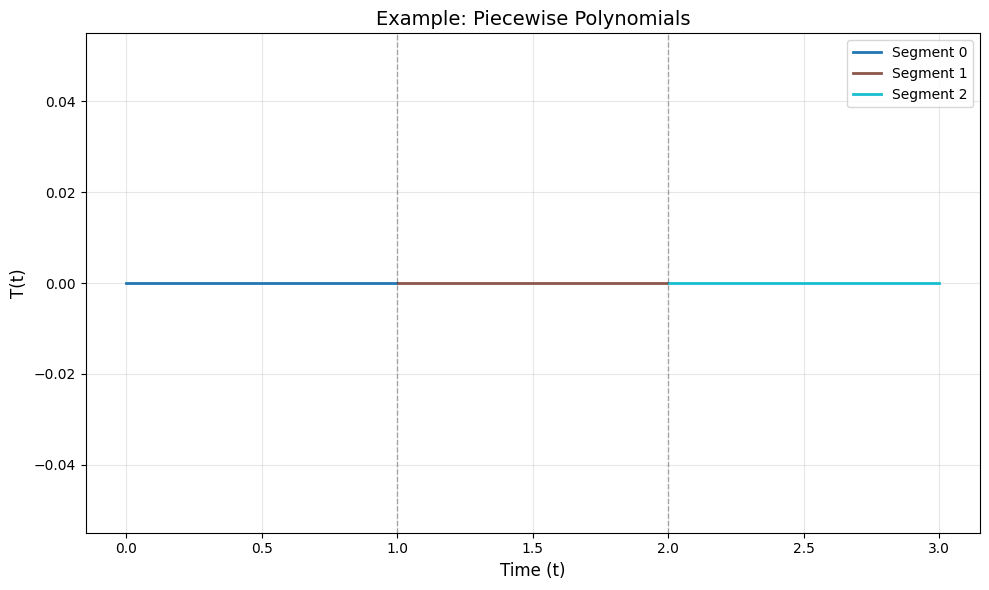

In [ ]:
# Make offset path 
# Quadratic Programming Setup with Arbitrary Boundary Conditions
order = 7
tau = 1.0
segments = 3
weights = [0, 1, 1, 1, 100.0, 1, 1, 1] # minimum snap

# Define boundary conditions for each segment
# boundary_conditions[k] = [val_at_0, val_at_tau] for segment k
# If None, no boundary constraint for that segment endpoint
boundary_conditions = [
    [0.0, None],      # Segment 0: start at 0, end is free
    [None, None],     # Segment 1: both free
    [None, 0.0],      # Segment 3: start is free, end at 1
]

# Get continuity constraints from get_big_A
# This gives us (K-1)*(order+1) = 3*5 = 15 constraints for continuity
A_continuity = get_big_A(order, tau, segments)
size = order + 1

# Build boundary constraint matrix
boundary_rows = []
boundary_values = []

for k, (start_val, end_val) in enumerate(boundary_conditions):
    # Constraint for segment start: P_k(0)
    if start_val is not None:
        row = np.zeros((1, segments * size))
        # At t=0, only the constant term (coefficient a_0) matters
        row[0, k*size] = 1.0  # P_k(0) = a_0
        boundary_rows.append(row)
        boundary_values.append(start_val)
    
    # Constraint for segment end: P_k(tau)
    if end_val is not None:
        row = np.zeros((1, segments * size))
        # P_k(tau) = a_0 + a_1*tau + a_2*tau^2 + ... + a_n*tau^n
        for n in range(size):
            row[0, k*size + n] = tau ** n
        boundary_rows.append(row)
        boundary_values.append(end_val)

# Combine all constraints
if boundary_rows:
    A_boundary = np.vstack(boundary_rows)
    A = ca.vertcat(A_continuity, ca.DM(A_boundary))
    b_continuity = ca.DM.zeros(A_continuity.shape[0], 1)

    # Enforce accleeration jump
    b_continuity[2] = -0.125
    b_continuity[10] = 0.125

    b_boundary = ca.DM(np.array(boundary_values).reshape(-1, 1))
    b = ca.vertcat(b_continuity, b_boundary)
else:
    # No boundary conditions, only continuity
    A = A_continuity
    b = ca.DM.zeros(A_continuity.shape[0], 1)



print("Boundary Conditions Setup:")
for k, (start_val, end_val) in enumerate(boundary_conditions):
    print(f"  Segment {k}: P_{k}(0) = {start_val}, P_{k}({tau}) = {end_val}")

print(f"\nConstraint matrix shapes:")
print(f"  A_continuity: {A_continuity.shape}")
if boundary_rows:
    print(f"  A_boundary: {A_boundary.shape}")
print(f"  A (total): {A.shape}")
print(f"  b (total): {b.shape}")

p = ca.SX.sym('p', (order+1)*(segments))

# Define QP objective
Q = Q_block_diagonal(order, tau, segments, weights=weights)

print(f"\nProblem dimensions:")
print(f"  Decision variables: {p.shape[0]}")
print(f"  Equality constraints: {A.shape[0]}")
print(f"  Q matrix shape: {Q.shape}")

objective = ca.mtimes(p.T, ca.mtimes(Q, p))

# Create optimizer
opts = {}
nlp = {'x': p, 'f': objective, 'g': ca.mtimes(A, p) - b}
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

# Solve with equality constraints (g = 0)
solution = solver(x0=ca.DM([0]*p.shape[0]), lbg=ca.DM([0]*b.shape[0]), ubg=ca.DM([0]*b.shape[0]))
x_opt = solution['x']
print("\nOptimal solution computed successfully")

import matplotlib.pyplot as plt
import numpy as np

def plot_piecewise_polynomials(polynomials, segment_times, t_eval=None, title="Piecewise Polynomial"):
    """
    Plot piecewise polynomials of the form:
    T(t) = P_0(t)           for 0 <= t <= tau_0
           P_1(t - tau_0)   for tau_0 < t <= tau_1 + tau_0
           P_2(t - (tau_0 + tau_1)) for tau_0 + tau_1 < t <= ...
    
    Args:
        polynomials: list boundary_conditionsof polynomial coefficient arrays or callables
                     each element p[i] is coefficients [a0, a1, a2, ...] for a0 + a1*t + a2*t^2 + ...
        segment_times: list of segment durations [tau_0, tau_1, tau_2, ...]
        t_eval: array of time points to evaluate. If None, auto-generate
        title: plot title
    """
    
    # Compute cumulative segment boundaries (Gamma_k)
    gamma = [0]
    for tau in segment_times:
        gamma.append(gamma[-1] + tau)
    
    # Auto-generate evaluation points if not provided
    if t_eval is None:
        t_eval = np.linspace(0, gamma[-1], 500)
    
    # Evaluate piecewise polynomial at each time and track segment indices
    T_values = np.zeros_like(t_eval)
    segment_indices = np.zeros_like(t_eval, dtype=int)
    for i, t in enumerate(t_eval):
        # Find which segment t belongs to
        for k in range(len(polynomials)):
            if gamma[k] < t <= gamma[k+1]:
                # Evaluate P_k(t - Gamma_k)
                t_local = t - gamma[k]
                if callable(polynomials[k]):
                    T_values[i] = polynomials[k](t_local)
                else:
                    # Assume polynomial coefficients [a0, a1, a2, ...]
                    T_values[i] = np.polyval(polynomials[k][::-1], t_local)
                segment_indices[i] = k
                break
        else:
            # t == 0 or t == gamma[0], use first segment
            if t == gamma[0] and len(polynomials) > 0:
                if callable(polynomials[0]):
                    T_values[i] = polynomials[0](0)
                else:
                    T_values[i] = np.polyval(polynomials[0][::-1], 0)
                segment_indices[i] = 0
    
    # Plot with different colors for each segment
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(polynomials)))
    
    # Plot each segment with a different color
    for k in range(len(polynomials)):
        segment_mask = segment_indices == k
        ax.plot(t_eval[segment_mask], T_values[segment_mask], color=colors[k], 
                linewidth=2, label=f'Segment {k}')
    
    # Mark segment boundaries
    for g in gamma[1:-1]:
        ax.axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Time (t)', fontsize=12)
    ax.set_ylabel('T(t)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return fig, ax

# Example usage: plot three quadratic polynomials
# P_0(t) = 1 + 2*t + t^2
# P_1(t) = 0.5*t + 0.5*t^2
# P_2(t) = 2 - t + 0.3*t^2

polys = np.array(x_opt).T.reshape(segments,order+1)

# polynomials_example = [
#     [1, 2, 1],      # coefficients for P_0
#     [0, 0.5, 0.5],  # coefficients for P_1
#     [2, -1, 0.3]    # coefficients for P_2
# ]
segment_times_example = [1.0, 1.0, 1.0]  # tau_0, tau_1, tau_2

fig, ax = plot_piecewise_polynomials(polys, segment_times_example, 
                                      title="Example: Piecewise Polynomials")
plt.tight_layout()
plt.show()


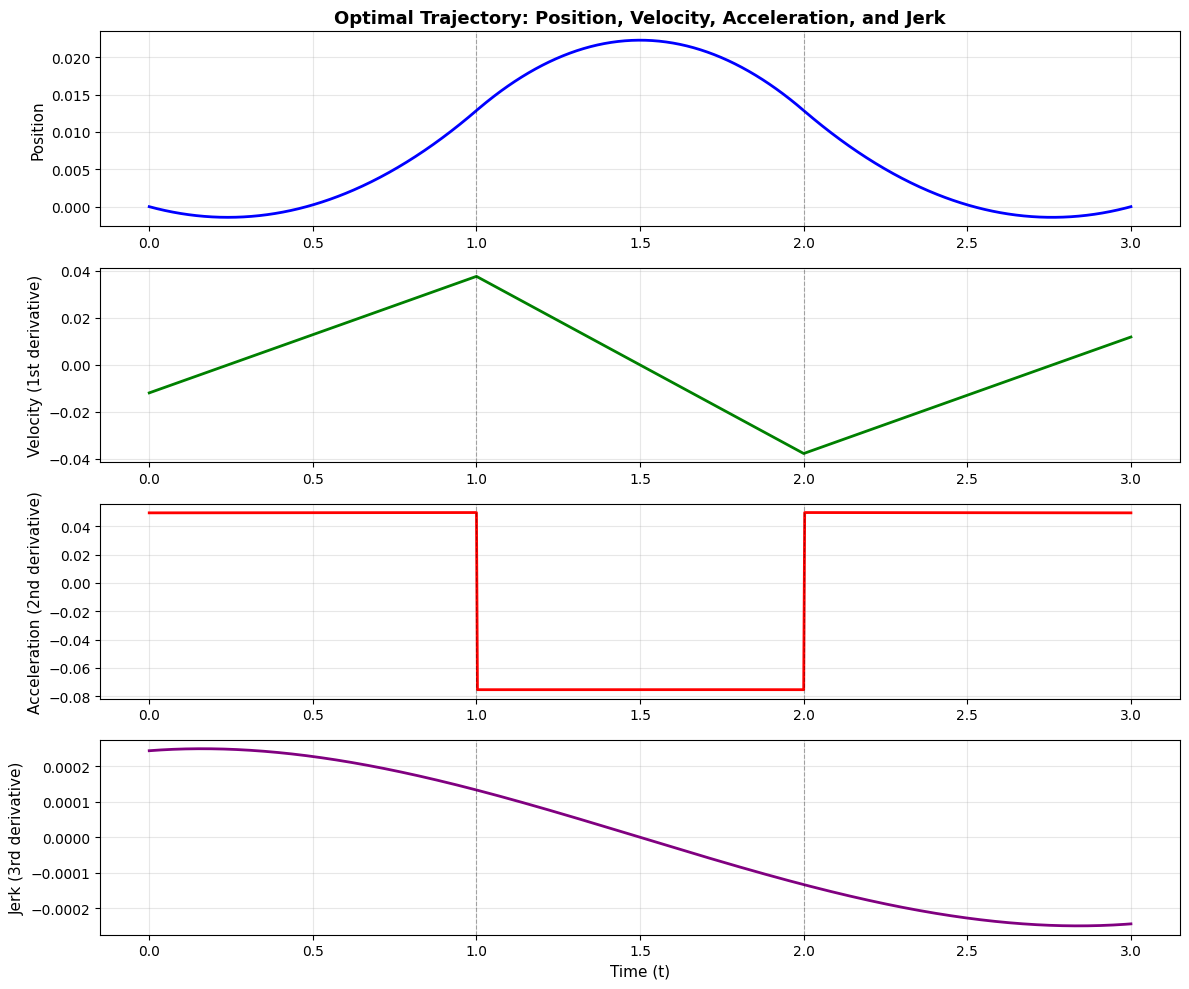

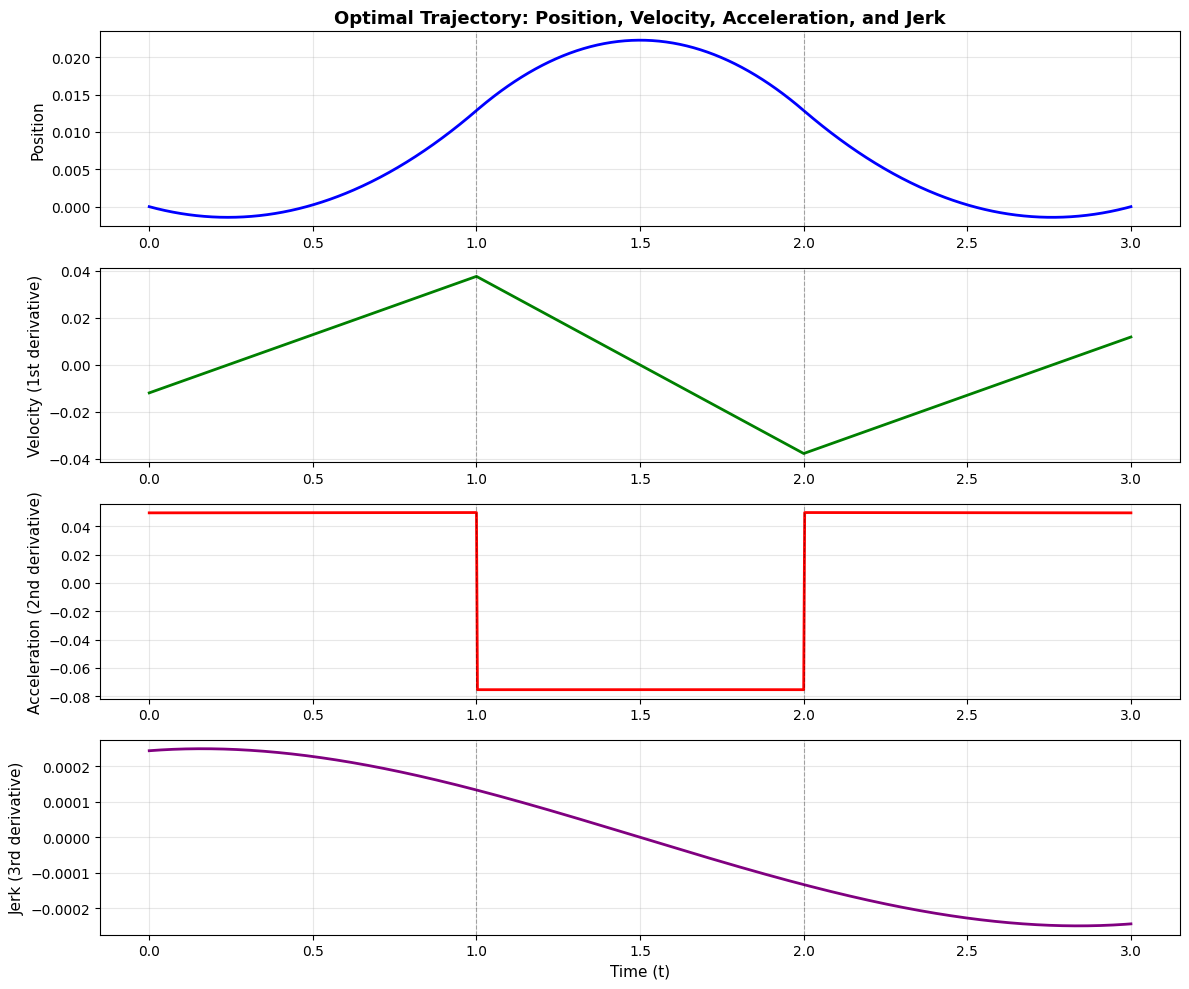

In [9]:
# Plot Position, Velocity, Acceleration, and Jerk (1st, 2nd, 3rd Derivatives)
# Plot Position, Velocity, Acceleration, and Jerk (1st, 2nd, 3rd Derivatives)

def compute_polynomial_derivative(coefficients, derivative_order=1):
    """
    Compute the coefficients of the derivative of a polynomial.
    
    Given polynomial P(t) = a_0 + a_1*t + a_2*t^2 + ... + a_n*t^n,
    returns coefficients of dP/dt = a_1 + 2*a_2*t + 3*a_3*t^2 + ...
    
    Args:
        coefficients: array [a_0, a_1, a_2, ..., a_n]
        derivative_order: which derivative to compute (1, 2, 3, ...)
    
    Returns:
        coefficients of the derivative polynomial
    """
    result = np.array(coefficients, dtype=float)
    for _ in range(derivative_order):
        if len(result) <= 1:
            return np.array([0.0])
        result = np.array([result[i] * i for i in range(1, len(result))])
    return result if len(result) > 0 else np.array([0.0])


def plot_derivatives(polynomials, segment_times, title="Trajectory Derivatives"):
    """
    Plot position, velocity (1st derivative), acceleration (2nd derivative),
    and jerk (3rd derivative) for a piecewise polynomial trajectory.
    
    Args:
        polynomials: array of shape (segments, order+1) with polynomial coefficients
        segment_times: list of segment durations
        title: plot title
    """
    # Compute cumulative segment boundaries (Gamma_k)
    gamma = [0]
    for tau in segment_times:
        gamma.append(gamma[-1] + tau)
    
    # Auto-generate evaluation points
    t_eval = np.linspace(0, gamma[-1], 1000)
    
    # Initialize arrays for each derivative order
    position = np.zeros_like(t_eval)
    velocity = np.zeros_like(t_eval)
    acceleration = np.zeros_like(t_eval)
    jerk = np.zeros_like(t_eval)
    
    # Compute derivatives for each segment
    derivatives = [None] * len(polynomials)  # 0th derivative (position)
    for k in range(len(polynomials)):
        # 0th order (position)
        derivatives[k] = [np.array(polynomials[k])]
        # 1st order (velocity)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 1))
        # 2nd order (acceleration)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 2))
        # 3rd order (jerk)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 3))
    
    # Evaluate at each time point
    for i, t in enumerate(t_eval):
        # Find which segment t belongs to
        for k in range(len(polynomials)):
            if gamma[k] <= t <= gamma[k+1]:
                t_local = t - gamma[k]
                # Evaluate all derivatives
                position[i] = np.polyval(derivatives[k][0][::-1], t_local)
                velocity[i] = np.polyval(derivatives[k][1][::-1], t_local) if len(derivatives[k][1]) > 0 else 0
                acceleration[i] = np.polyval(derivatives[k][2][::-1], t_local) if len(derivatives[k][2]) > 0 else 0
                jerk[i] = np.polyval(derivatives[k][3][::-1], t_local) if len(derivatives[k][3]) > 0 else 0
                break
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Plot position
    axes[0].plot(t_eval, position, 'b-', linewidth=2)
    axes[0].set_ylabel('Position', fontsize=11)
    axes[0].set_title(title, fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[0].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot velocity (1st derivative)
    axes[1].plot(t_eval, velocity, 'g-', linewidth=2)
    axes[1].set_ylabel('Velocity (1st derivative)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[1].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot acceleration (2nd derivative)
    axes[2].plot(t_eval, acceleration, 'r-', linewidth=2)
    axes[2].set_ylabel('Acceleration (2nd derivative)', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[2].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot jerk (3rd derivative)
    axes[3].plot(t_eval, jerk, 'purple', linewidth=2)
    axes[3].set_ylabel('Jerk (3rd derivative)', fontsize=11)
    axes[3].set_xlabel('Time (t)', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[3].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    return fig, axes


# Plot the derivatives
fig_derivs, axes_derivs = plot_derivatives(polys, segment_times_example, 
                                           title="Optimal Trajectory: Position, Velocity, Acceleration, and Jerk")
plt.show()
def compute_polynomial_derivative(coefficients, derivative_order=1):
    """
    Compute the coefficients of the derivative of a polynomial.
    
    Given polynomial P(t) = a_0 + a_1*t + a_2*t^2 + ... + a_n*t^n,
    returns coefficients of dP/dt = a_1 + 2*a_2*t + 3*a_3*t^2 + ...
    
    Args:
        coefficients: array [a_0, a_1, a_2, ..., a_n]
        derivative_order: which derivative to compute (1, 2, 3, ...)
    
    Returns:
        coefficients of the derivative polynomial
    """
    result = np.array(coefficients, dtype=float)
    for _ in range(derivative_order):
        if len(result) <= 1:
            return np.array([0.0])
        result = np.array([result[i] * i for i in range(1, len(result))])
    return result if len(result) > 0 else np.array([0.0])


def plot_derivatives(polynomials, segment_times, title="Trajectory Derivatives"):
    """
    Plot position, velocity (1st derivative), acceleration (2nd derivative),
    and jerk (3rd derivative) for a piecewise polynomial trajectory.
    
    Args:
        polynomials: array of shape (segments, order+1) with polynomial coefficients
        segment_times: list of segment durations
        title: plot title
    """
    # Compute cumulative segment boundaries (Gamma_k)
    gamma = [0]
    for tau in segment_times:
        gamma.append(gamma[-1] + tau)
    
    # Auto-generate evaluation points
    t_eval = np.linspace(0, gamma[-1], 1000)
    
    # Initialize arrays for each derivative order
    position = np.zeros_like(t_eval)
    velocity = np.zeros_like(t_eval)
    acceleration = np.zeros_like(t_eval)
    jerk = np.zeros_like(t_eval)
    
    # Compute derivatives for each segment
    derivatives = [None] * len(polynomials)  # 0th derivative (position)
    for k in range(len(polynomials)):
        # 0th order (position)
        derivatives[k] = [np.array(polynomials[k])]
        # 1st order (velocity)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 1))
        # 2nd order (acceleration)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 2))
        # 3rd order (jerk)
        derivatives[k].append(compute_polynomial_derivative(polynomials[k], 3))
    
    # Evaluate at each time point
    for i, t in enumerate(t_eval):
        # Find which segment t belongs to
        for k in range(len(polynomials)):
            if gamma[k] <= t <= gamma[k+1]:
                t_local = t - gamma[k]
                # Evaluate all derivatives
                position[i] = np.polyval(derivatives[k][0][::-1], t_local)
                velocity[i] = np.polyval(derivatives[k][1][::-1], t_local) if len(derivatives[k][1]) > 0 else 0
                acceleration[i] = np.polyval(derivatives[k][2][::-1], t_local) if len(derivatives[k][2]) > 0 else 0
                jerk[i] = np.polyval(derivatives[k][3][::-1], t_local) if len(derivatives[k][3]) > 0 else 0
                break
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Plot position
    axes[0].plot(t_eval, position, 'b-', linewidth=2)
    axes[0].set_ylabel('Position', fontsize=11)
    axes[0].set_title(title, fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[0].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot velocity (1st derivative)
    axes[1].plot(t_eval, velocity, 'g-', linewidth=2)
    axes[1].set_ylabel('Velocity (1st derivative)', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[1].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot acceleration (2nd derivative)
    axes[2].plot(t_eval, acceleration, 'r-', linewidth=2)
    axes[2].set_ylabel('Acceleration (2nd derivative)', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[2].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # Plot jerk (3rd derivative)
    axes[3].plot(t_eval, jerk, 'purple', linewidth=2)
    axes[3].set_ylabel('Jerk (3rd derivative)', fontsize=11)
    axes[3].set_xlabel('Time (t)', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    for g in gamma[1:-1]:
        axes[3].axvline(x=g, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    return fig, axes


# Plot the derivatives
fig_derivs, axes_derivs = plot_derivatives(polys, segment_times_example, 
                                           title="Optimal Trajectory: Position, Velocity, Acceleration, and Jerk")
plt.show()

In [ ]:
a = [[1, 2],[3,4],[5,6]]
b = [[7, 8],[9,10],[11,12]]

conds = [a,b]


# Alternative approach using numpy for cleaner code
import numpy as np
a_arr = np.array(a).flatten()
b_arr = np.array(b).flatten()
combined_alt = []
for x, y in zip(a_arr, b_arr):
    combined_alt.extend([x, y])

print(f"Combined (alternative): {combined_alt}")

Original conditions:
a = [[1, 2], [3, 4], [5, 6]]
b = [[7, 8], [9, 10], [11, 12]]

Combined vector: [1, 7, 2, 8, 3, 9, 4, 10, 5, 11, 6, 12]
Combined (alternative): [np.int64(1), np.int64(7), np.int64(2), np.int64(8), np.int64(3), np.int64(9), np.int64(4), np.int64(10), np.int64(5), np.int64(11), np.int64(6), np.int64(12)]
